In [ ]:
# This notebook shows how gather data from elasticsearch server

In [4]:
from elasticsearch import Elasticsearch
from pandasticsearch import Select
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

pd.options.mode.chained_assignment = None

es_hostname = "http://94.158.21.216/"
es = Elasticsearch([es_hostname])

In [5]:
def helper_query_es(es, index, query):
    size = 10000
    # Init scroll by search
    data = es.search(
        index=index,
        scroll='2m',
        size=size,
        body=query
    )
    # Get the scroll ID
    sid = data['_scroll_id']
    scroll_size = len(data['hits']['hits'])
    hits = []
    while scroll_size > 0:
        # Before scroll, process current batch of hits
        for hit in data['hits']['hits']:
            hits.append(hit)
        # process_hits(data['hits']['hits'])
        data = es.scroll(scroll_id=sid, scroll='2m')
        # Update the scroll ID
        sid = data['_scroll_id']
        # Get the number of results returned in the last scroll
        scroll_size = len(data['hits']['hits'])
    es.clear_scroll(scroll_id=sid)
    result_dict = {'took': 0, 'hits': {'hits': hits}}
    return result_dict

In [6]:
query = {
  "query": {
    "range": {
      "user.created_at": {
        "gte": "",
        "lte": "",
        "format": "dd/MM/yyyy"
      }
    }
  }
}

dates = ['02/02/2020', '02/11/2020', '07/11/2020']

In [ ]:
# Using the gathered data to make plots

In [13]:
def analyze(query, date):
    query['query']['range']['user.created_at']['gte'] = date
    query['query']['range']['user.created_at']['lte'] = date
    res = helper_query_es(es, 'tweets', query)
    
    df = Select.from_dict(res).to_pandas()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['user.created_at'] = pd.to_datetime(df['user.created_at'])
    
    print('Daily distribution based on account creation time')
    daily_distribution = df.groupby(pd.Grouper(freq='30 min', key='user.created_at')).agg({'user.id_str': pd.Series.nunique})
    daily_distribution = daily_distribution.reset_index()
    daily_distribution = daily_distribution.rename({'user.id_str': 'n_users'}, axis=1)
    daily_distribution.plot(x='user.created_at', y='n_users')
    plt.show()


    tweeted_same_day = df[df['created_at'].dt.strftime('%d/%m/%Y') == date]
    print('In ' + date + ', ' + str(tweeted_same_day['user.id_str'].nunique()) + ' out of ' + str(df['user.id_str'].nunique()) + ' accounts tweeted the same day of their creation')
    tweeted_same_day['tot_mins_diff'] = (tweeted_same_day['created_at'] - tweeted_same_day['user.created_at']) / pd.Timedelta(minutes=1)
    bins = [0, 5, 10, 30, 60, 120, 240, 480, np.inf]
    labels = ['5m', '10m', '30m', '1h', '2h', '4h', '8h', '+8h']
    tweeted_same_day_grouped=tweeted_same_day.groupby(pd.cut(tweeted_same_day['tot_mins_diff'], bins=bins, labels=labels)).size().reset_index(name='count')
    tweeted_same_day_grouped.plot.bar(x='tot_mins_diff', y='count')
    plt.show()
    
    tweeted_30min = tweeted_same_day[tweeted_same_day['tot_mins_diff'] <= 30]
    
    print(str(len(tweeted_30min)) + ' accounts tweeted within 30 minutes since their creation' )
    
    tweeted_2h = tweeted_same_day[tweeted_same_day['tot_mins_diff'] <= 120]

    print(str(len(tweeted_2h)) + ' accounts tweeted within 2 hours since their creation' )


Daily distribution based on account creation time


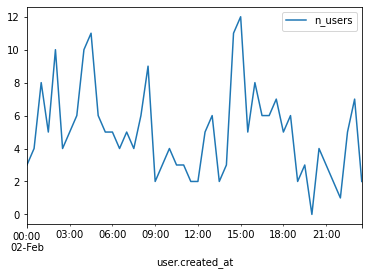

In 02/02/2020, 122 out of 240 accounts tweeted the same day of their creation


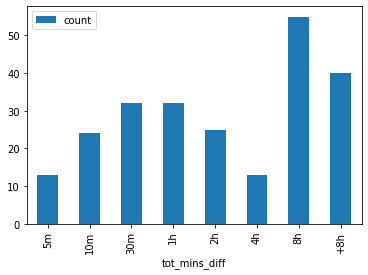

69 accounts tweeted within 30 minutes since their creation
126 accounts tweeted within 2 hours since their creation


In [14]:
analyze(query, dates[0]) #02/02/2020

Daily distribution based on account creation time


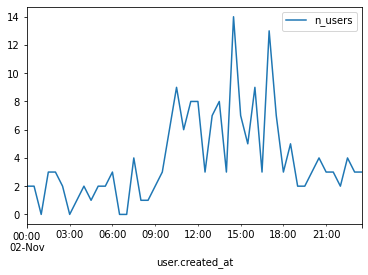

In 02/11/2020, 61 out of 187 accounts tweeted the same day of their creation


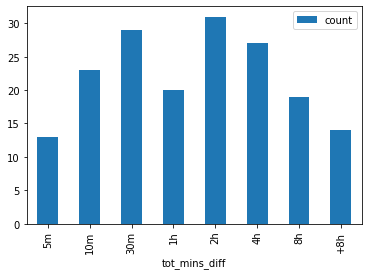

65 accounts tweeted within 30 minutes since their creation
116 accounts tweeted within 2 hours since their creation


In [15]:
analyze(query, dates[1]) #02/11/2020

Daily distribution based on account creation time


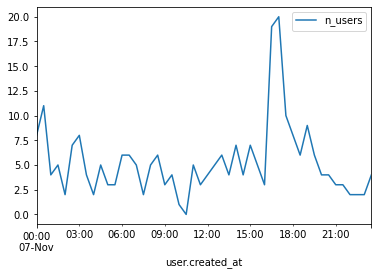

In 07/11/2020, 101 out of 255 accounts tweeted the same day of their creation


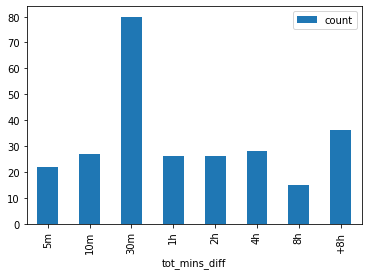

129 accounts tweeted within 30 minutes since their creation
181 accounts tweeted within 2 hours since their creation


In [16]:
analyze(query, dates[2]) #07/11/2020